# OCR Agent from scratch:

* [Data](Data-Sources.ipynb)
* [Utilities](Data-Processing.ipynb)
* [Extract layout features and visual tokens](Data-Extraction-2.ipynb)
* [Generate training data](Data-Extraction-3.ipynb)
* Model architecture
    * [Visual encoder, generative and discriminative heads](Model-Backbone.ipynb)
    * Unsupervised and semi-supervise pretraining
    * [Supervised multi-task training](Model-Training.ipynb)
* [Traversal strategies](Traversal-Layout.ipynb)
* [Reader Agent](Agent-LM.ipynb)
* [Leverage synthetic training data](Data-Gen.ipynb)
* [Optimization for production](Optimization.ipynb)



### Visual encoder pre-training strategies
Common strategy for unsupervised visual pretraining is missing patch prediction.
In the case of doc-views it makes sense to use denoising and restoration tasks as unsupervised pretraining.
Orientation detection also makes sense here as a semi-supervised strategy.

In [1]:
import json
import torch
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from matplotlib import pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim import SGD, AdamW
from torchsummary import summary
from torchmetrics import ConfusionMatrix

In [2]:
from scripts.training import *

In [3]:
torch.cuda.empty_cache()
print('GPU' if DEVICE == 'cuda' else 'no GPU')

GPU


<a name="data"></a>

## Dataset
Training dataset focused on our main task: character-level token view encoding (feature extraction).

In [4]:
len(trainset)

7679

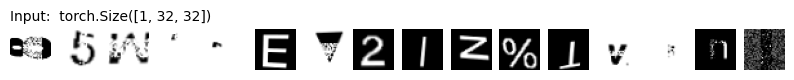

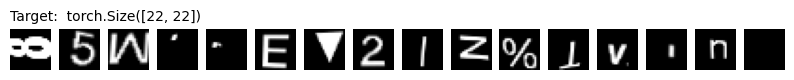

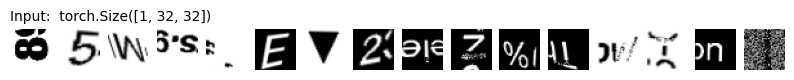

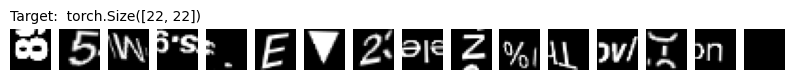

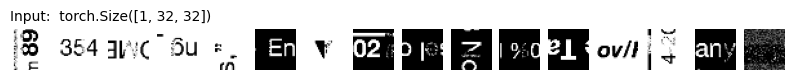

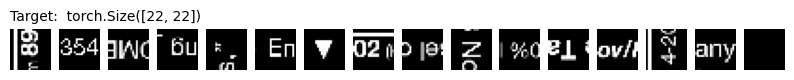

tensor([3, 0, 2, 2, 3, 0, 1, 0, 2, 1, 2, 2, 0, 3, 0, 0])


In [5]:
source = np.random.choice(testset)

# pick the batch for evaluation
for demo_batch in DataLoader(PretrainingDataset(source, INDEX, transform=1.), batch_size=16, shuffle=True):
    X, Y, L = demo_batch
    for i in range(len(X)):
        show_inputs(X[i])
        show_targets(Y[i])
    break
print(L[-1])

<a name="exp"></a>

## Model
For the completely unsupervised version we would use:

    model = MultiVAE(encoder, latent_dim)
    
We go with semi-supervised version instead. With our `MultiVAE` architecture we can explore several different ways: attaching `align`-classifier to each component, passing a separate `consensus`-classifier, or any combination of both as down the line we will need the reliable rotation detector.

    1. model = MultiVAE(encoder, latent_dim, num_classes=4)
        
    2. semantic = OrientationConsensus(model.keys, latent_dim, 4)
        
    3. semantic = ContextClassifier(model.keys, latent_dim, 4)
    
    4. model = MultiVAE(encoder, latent_dim, semantic=semantic)

    5. model = MultiVAE(encoder, latent_dim, num_classes=4, semantic=semantic)
    
    
For POC let's start from the first simplest exploratory setup.

In [6]:
latent_dim = 64
num_classes = 4

encoder = get_encoder()
model = MultiVAE(encoder, latent_dim, num_classes).to(DEVICE)

In [7]:
for i, out in enumerate(model([x.to(DEVICE) for x in X])):
    print(model.keys[i], out.size() if out is not None else 'NaN')

concept-rec torch.Size([16, 1, 22, 22])
concept-z torch.Size([16, 64])
concept-mean torch.Size([16, 64])
concept-log-var torch.Size([16, 64])
concept-tau torch.Size([1])
concept-z-context torch.Size([16, 64])
concept-label torch.Size([16, 4])
target-rec torch.Size([16, 1, 22, 22])
target-z torch.Size([16, 64])
target-mean torch.Size([16, 64])
target-log-var torch.Size([16, 64])
target-tau torch.Size([1])
target-z-context torch.Size([16, 64])
target-label torch.Size([16, 4])
context-rec torch.Size([16, 1, 22, 22])
context-z torch.Size([16, 64])
context-mean torch.Size([16, 64])
context-log-var torch.Size([16, 64])
context-tau torch.Size([1])
context-z-context torch.Size([16, 64])
context-label torch.Size([16, 4])


## Training

In [8]:
VAE(get_encoder(), get_decoder(), latent_dim).keys

['rec', 'z', 'mean', 'log-var', 'tau', 'z-context', 'label']

In [9]:
class PretrainLoss(nn.Module):
    tags = ['concept','target','context'] # model-components
    
    def __init__(self, keys: list, config: dict):
        super().__init__()
        self.keys = keys
        keys = ['rec','z','mean','log-var','tau','z-context','label'] # vae outputs
        for tag in self.tags:
            setattr(self, tag, VAELoss(keys, config[tag], align=nn.CrossEntropyLoss()))
        
    def forward(self, outputs, targets, labels):
        loss, metrics = [], {}
        # encoders-align
        for i, tag in enumerate(['concept','target','context']):
            r, l = self.keys.index(f'{tag}-rec'), self.keys.index(f'{tag}-label')
            tag_loss, tag_metrics = getattr(self, tag)(outputs[r:l + 1], targets[i], labels[1])
            metrics = {**metrics, **{f'{tag}-{k}':v for k,v in tag_metrics.items()}}
            loss.append(tag_loss)
        loss = torch.sum(torch.stack(loss))
        return loss, metrics


In [ ]:
PATH = f'VAE-{latent_dim}'
#model.load_state_dict(torch.load(f'./models/{PATH}.pt'))

In [ ]:
batch_size = 16
learning_rate = 5e-6
epochs = 5
start = 1

config = {'concept': {'Reconstruction':8., 'KLD':-2., 'Contrast':0., 'Align':4.},
          'target':  {'Reconstruction':8., 'KLD':-3., 'Contrast':1., 'Align':4.},
          'context': {'Reconstruction':8., 'KLD':-4., 'Contrast':2., 'Align':4.}}

criterion = PretrainLoss(model.keys, config).to(DEVICE)
#criterion.load_state_dict(torch.load(f'./models/{PATH}-criterion.pt'))

params = [p for p in model.parameters()] + [p for p in criterion.parameters()]
optimizer = SGD(params, lr=learning_rate, momentum=0.9)
#optimizer.load_state_dict(torch.load(f'./models/{PATH}-optimizer.pt'))

history = {'train':[],'test':[]}
for epoch in range(start, epochs + 1):
    for i, source in enumerate(np.random.permutation(trainset), 1):
        train_history = train(model, PretrainingDataset(source, INDEX),
                              criterion, optimizer, batch_size=batch_size)
        test_history = validate(model, PretrainingDataset(np.random.choice(testset), INDEX),
                                criterion, batch_size=batch_size)
        # track epoch avg loss
        history['train'].append(pd.DataFrame.from_dict(train_history).mean().to_dict())
        history['test'].append(pd.DataFrame.from_dict(test_history).mean().to_dict())
        print(f"Epoch {epoch}: {i/len(trainset):<7.2%}  "
              f"train: {history['train'][-1]['Loss']:<5.0f}  "
              f"test: {history['test'][-1]['Loss']:<5.0f}  "
              f"concept-align: {history['test'][-1]['concept-Align']:<5.2f}  "
              f"target-align: {history['test'][-1]['target-Align']:<5.2f}  "
              f"context-align: {history['test'][-1]['context-Align']:<.2f}  "
              , end='\r')
    
    torch.save(model.state_dict(), f'./models/{PATH}.pt')
    with open(f'./output/{PATH}-{epoch}.json','w') as output:
        json.dump(history, output)
        history = {'train':[],'test':[]}

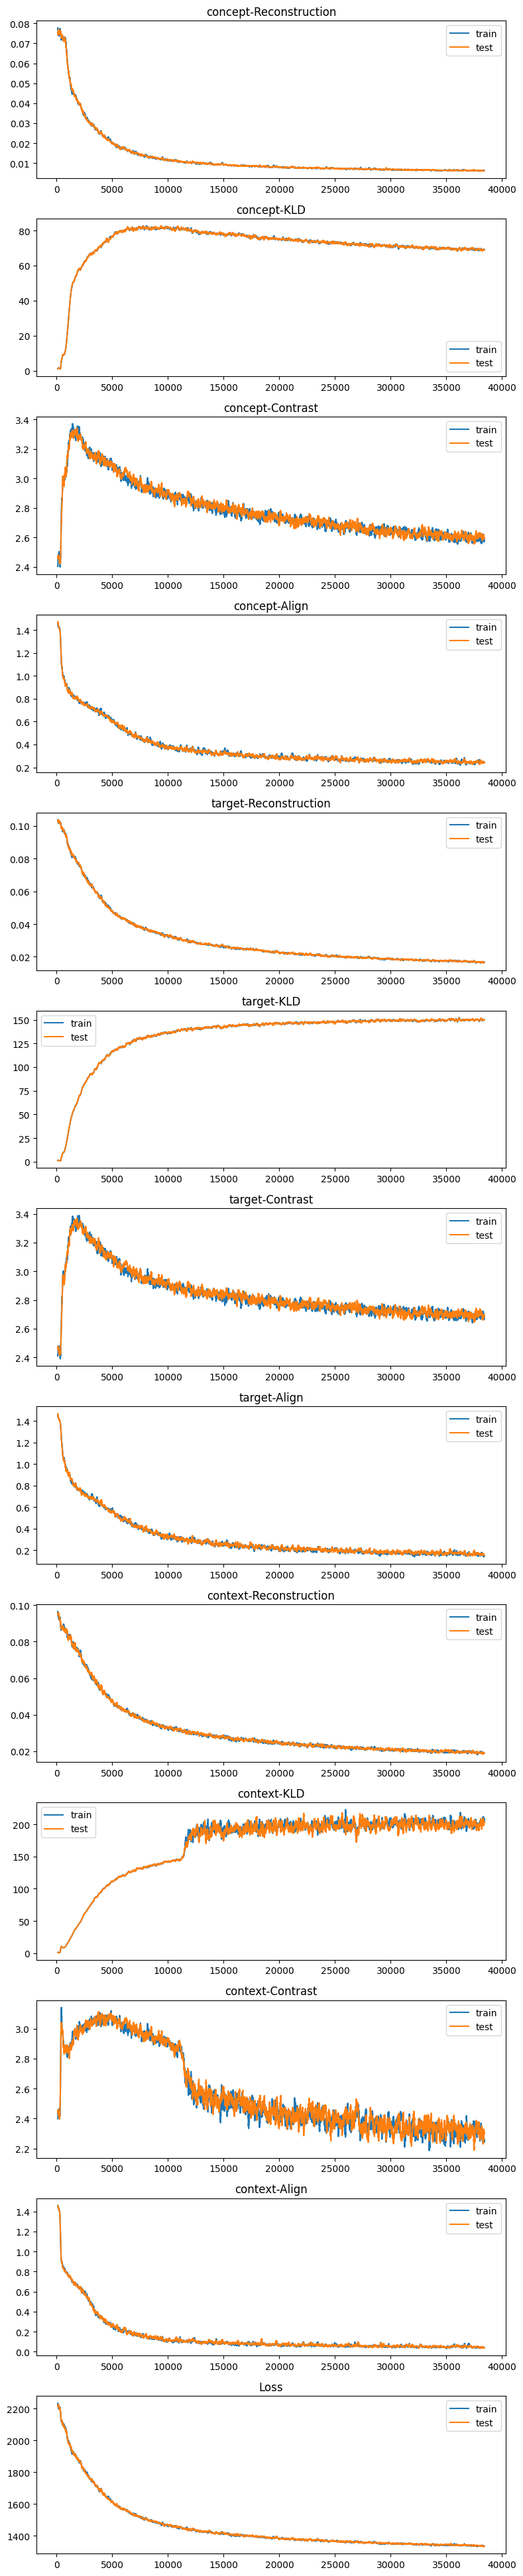

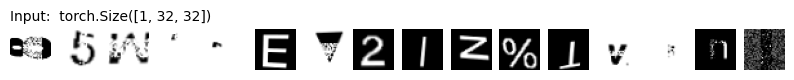

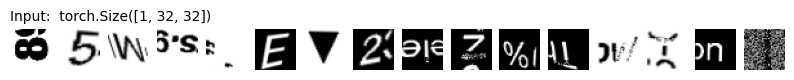

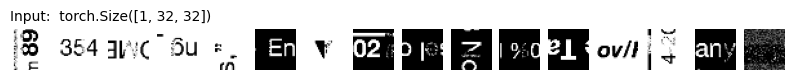


------- concept output ----------------------------------------------------


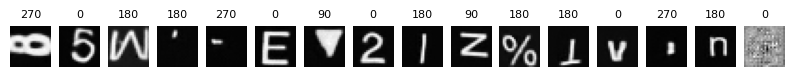


------- target  output ----------------------------------------------------


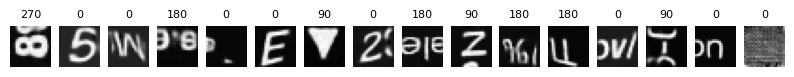


------- context output ----------------------------------------------------


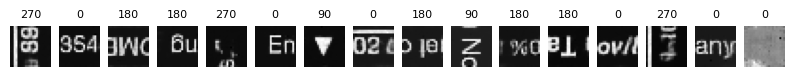

In [13]:
# save trained encoder for use
torch.save(encoder.state_dict(), './models/backbone-encoder.pt')

# for continuing training
torch.save(criterion.state_dict(), f'./models/{PATH}-criterion.pt')
torch.save(optimizer.state_dict(), f'./models/{PATH}-optimizer.pt')

plot_results(PATH, window=100, save=True)

X, Y, L = demo_batch
show_inputs(X[0])
show_inputs(X[1])
show_inputs(X[2])
with torch.no_grad():
    model.eval()
    n = len(X[0])
    output = model([x.to(DEVICE) for x in X])
    for j, m in enumerate(model.tags):
        print(f'\n------- {m:<7} output ----------------------------------------------------')
        a, b = model.keys.index(f'{m}-rec'), model.keys.index(f'{m}-label')
        fig, ax = plt.subplots(1, n, figsize=(10, 10))
        R = output[a].cpu().squeeze().numpy()
        P = torch.argmax(torch.softmax(output[b], dim=1), dim=1).cpu().numpy()
        for i in range(n):
            ax[i].imshow(R[i,:], 'gray')
            ax[i].axis('off')
            ax[i].set_title(f'{[0, 90, 180, 270][P[i]]}', fontsize=8)
        plt.show()

## Evaluation

In [14]:
confmat = ConfusionMatrix(task='multiclass', num_classes=4).to(DEVICE)
matrix = np.zeros((3, 4, 4))

model.eval()
with torch.no_grad():
    for source in testset:
        loader = DataLoader(PretrainingDataset(source, INDEX), batch_size=16)
        for batch in loader:
            X, Y, L = batch
            n = len(X[0])
            output = model([x.to(DEVICE) for x in X])
            for i, m in enumerate(model.tags):
                P = torch.argmax(torch.softmax(output[model.keys.index(f'{m}-label')], dim=1), dim=1)
                matrix[i,:,:] += confmat(P, L[-1].to(DEVICE)).cpu().numpy()

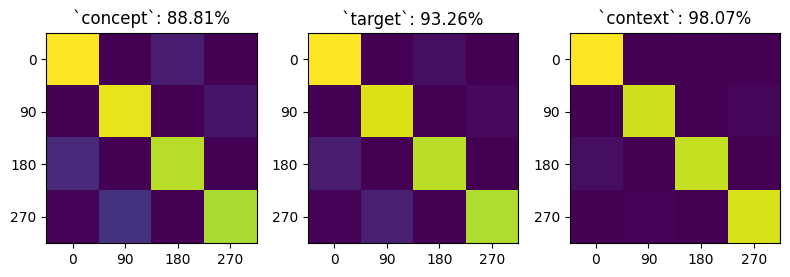

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
for i, m in enumerate(model.tags):
    ax[i].imshow(matrix[i,:,:])
    ax[i].set_xticks(range(4))
    ax[i].set_yticks(range(4))
    ax[i].set_xticklabels([0, 90, 180, 270])
    ax[i].set_yticklabels([0, 90, 180, 270])
    ax[i].set_title(f'`{m}`: {matrix[i,:,:].trace()/matrix[i,:,:].sum():.2%}')
plt.savefig(f'./output/{PATH}-orientation.png')
plt.tight_layout()

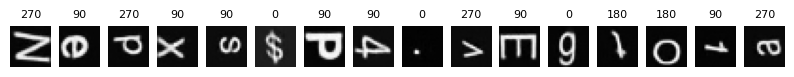

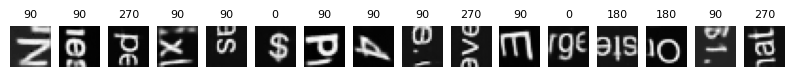

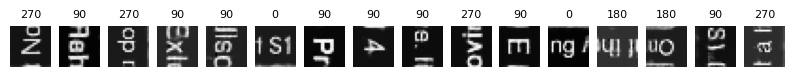

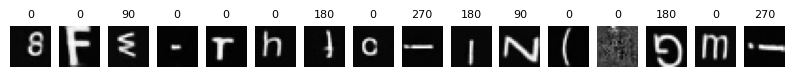

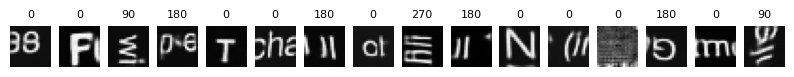

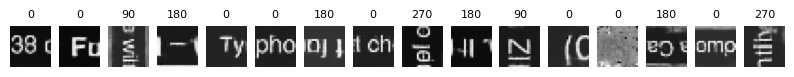

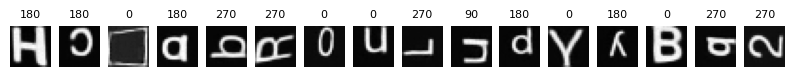

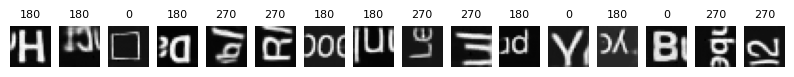

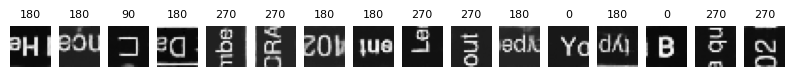

In [16]:
model.eval()
with torch.no_grad():
    source = np.random.choice(testset)
    #loader = DataLoader(PretrainingDataset(source, amp=16), batch_size=16) # see full batch of each class
    loader = DataLoader(PretrainingDataset(source, INDEX), batch_size=16)
    for X, Y, L in loader:
        n = len(X[0])
        if n < 16: break
        output = model([x.to(DEVICE) for x in X])
        for j, m in enumerate(model.tags):
            a, b = model.keys.index(f'{m}-rec'), model.keys.index(f'{m}-label')
            fig, ax = plt.subplots(1, 16, figsize=(10, 10))
            R = output[a].cpu().squeeze().numpy()
            P = torch.argmax(torch.softmax(output[b], dim=1), dim=1).cpu().numpy()
            for i in range(16):
                ax[i].imshow(R[i,:], 'gray')
                ax[i].axis('off')
                ax[i].set_title(f'{[0, 90, 180, 270][P[i]]}', fontsize=8)
            plt.show()
        print(' ')

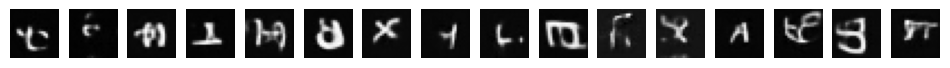

In [17]:
# generate some `concept` samples
model.eval()
with torch.no_grad():
    samples = model.concept.sample(16).squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 16, figsize=(12, 12))
    for i in range(16):
        ax[i].imshow(samples[i,:], 'gray')
        ax[i].axis('off')
    plt.show()

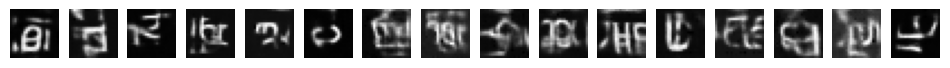

In [18]:
# generate some `focus` samples
model.eval()
with torch.no_grad():
    samples = model.target.sample(16).squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 16, figsize=(12, 12))
    for i in range(16):
        ax[i].imshow(samples[i,:], 'gray')
        ax[i].axis('off')
    plt.show()

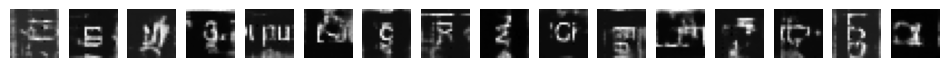

In [19]:
# generate some `context` samples
model.eval()
with torch.no_grad():
    samples = model.context.sample(16).squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 16, figsize=(12, 12))
    for i in range(16):
        ax[i].imshow(samples[i,:], 'gray')
        ax[i].axis('off')
    plt.show()

Takeaway: as expected the `context` model is the best to detect rotation.